#Connect to Google Drive, unzip dataset and define general variables

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!rm -rf '/content/drive/MyDrive/faceRecognition/dataSplit'
!unzip '/content/drive/MyDrive/faceRecognition/dataSplit.zip' -d '/content/drive/MyDrive/faceRecognition/'

import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[0], 'GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

train_data_dir = '/content/drive/MyDrive/faceRecognition/dataSplit/train/'
test_data_dir = '/content/drive/MyDrive/faceRecognition/dataSplit/test/'
validation_data_dir = '/content/drive/MyDrive/faceRecognition/dataSplit/validation/'

IMG_HEIGHT = 197
IMG_WIDTH = 197
color='rgb'
#IMG_HEIGHT = 48
#IMG_WIDTH = 48
#color='grayscale'
input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
batch_size = 128
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/faceRecognition/dataSplit/train/surprise/Training_80022808.jpg  
  inflating: /content/drive/MyDrive/faceRecognition/dataSplit/train/surprise/Training_80303562.jpg  
  inflating: /content/drive/MyDrive/faceRecognition/dataSplit/train/surprise/Training_80446106.jpg  
  inflating: /content/drive/MyDrive/faceRecognition/dataSplit/train/surprise/Training_80515990.jpg  
  inflating: /content/drive/MyDrive/faceRecognition/dataSplit/train/surprise/Training_80557580.jpg  
  inflating: /content/drive/MyDrive/faceRecognition/dataSplit/train/surprise/Training_80565344.jpg  
  inflating: /content/drive/MyDrive/faceRecognition/dataSplit/train/surprise/Training_80596096.jpg  
  inflating: /content/drive/MyDrive/faceRecognition/dataSplit/train/surprise/Training_80632771.jpg  
  inflating: /content/drive/MyDrive/faceRecognition/dataSplit/train/surprise/Training_80644218.jpg  
  inflating: /content/drive/MyDrive/face

# New Section

#Define general functions

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

def prepare_data(dir, color='grayscale', aug=False):
    if aug:
        datagen = ImageDataGenerator(
                                rescale=1./255,
                                featurewise_center=False,
                                featurewise_std_normalization=False,
                                rotation_range=10,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range=0.1,
                                horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
        dir,
        color_mode=color,
        target_size=(input_shape[0], input_shape[1]),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

def plot_model_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'])
    axs[0].plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'val'], loc='best')

    axs[1].plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
    axs[1].plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'val'], loc='best')

    fig.savefig('train.png')
    plt.show()

train_generator = prepare_data(train_data_dir, color=color, aug=True)
test_generator = prepare_data(test_data_dir, color=color)
validation_generator = prepare_data(validation_data_dir, color=color)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


#Five layer baseline model

In [ ]:
"""
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.losses import CategoricalCrossentropy

# Initialize the model
model = Sequential()

# Add the first convolutional layer
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Add the second convolutional layer
model.add(Conv2D(32, kernel_size=(4, 4), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Add the third convolutional layer
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Flatten the tensor output from the convolutional layers
model.add(Flatten())

# Add the fully connected layer
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Add the output layer
model.add(Dense(7, activation='softmax')) # assuming 10 classes for CIFAR-10 dataset

# Configure the learning process
optimizer = SGD(learning_rate=0.1, momentum=0.9, decay=0.0001)
model.compile(loss=CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])
"""

In [ ]:
!pip install keras_vggface
!pip install keras_applications
!pip install keras.engine.topology
#https://github.com/amilkh/cs230-fer/blob/master/models/tf-ResNet50.ipynb

'''
I solved this issue by changing the import from
from keras.engine.topology import get_source_inputs
to
from keras.utils.layer_utils import get_source_inputs in keras_vggface/models.py.
'''
!nvidia-smi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.7 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement keras.engine.topology (from versions: none)
ERROR: No matching distribution found for keras.engine.topology
Sun Sep  3 08:03:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W /  70W |    387MiB / 15360MiB |      0%      Default

#Next code is common for all the ResNet50 models

In [ ]:
from keras_vggface.vggface import VGGFace
from keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 170

vgg_notop = VGGFace(model='resnet50', include_top=False, input_shape=(input_shape[0], input_shape[1], 3), pooling='avg')
rlrop = ReduceLROnPlateau(monitor='val_accuracy',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)
batch_norm_indices = [2, 6, 9, 13, 14, 18, 21, 24, 28, 31, 34, 38, 41, 45, 46, 53, 56, 60, 63, 66, 70, 73, 76, 80, 83, 87, 88, 92, 95, 98, 102, 105, 108, 112, 115, 118, 122, 125, 128, 132, 135, 138, 142, 145, 149, 150, 154, 157, 160, 164, 167, 170]

device_name = tf.test.gpu_device_name()

#ResNet50 Adam

In [ ]:
'''
with tf.device(device_name):
  model = Sequential()
  model.add(vgg_notop)
  model.add(Flatten(name='flatten'))
  model.add(Dropout(DROPOUT_RATE))
  model.add(Dense(4096, activation='relu', name='fc6'))
  model.add(Dropout(DROPOUT_RATE))
  model.add(Dense(1024, activation='relu', name='fc7'))
  model.add(Dropout(DROPOUT_RATE))
  model.add(Dense(7, activation='softmax', name='classifier'))

  for i in range(FROZEN_LAYER_NUM):
      if i not in batch_norm_indices:
          model.layers[0].layers[i].trainable = False
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  '''

#ResNet50 SGD without Nesterov

In [ ]:
'''
sgd = SGD(lr=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY)
with tf.device(device_name):
  model = Sequential()
  model.add(vgg_notop)
  model.add(Flatten(name='flatten'))
  model.add(Dropout(DROPOUT_RATE))
  model.add(Dense(4096, activation='relu', name='fc6'))
  model.add(Dropout(DROPOUT_RATE))
  model.add(Dense(1024, activation='relu', name='fc7'))
  model.add(Dropout(DROPOUT_RATE))
  model.add(Dense(7, activation='softmax', name='classifier'))

  for i in range(FROZEN_LAYER_NUM):
      if i not in batch_norm_indices:
          model.layers[0].layers[i].trainable = False
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
'''

94694792/94694792 [==============================] - 1s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


#ResNet50 SGD with Nesterov

In [ ]:
sgd = SGD(lr=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY, nesterov=True)

with tf.device(device_name):
  model = Sequential()
  model.add(vgg_notop)
  model.add(Flatten(name='flatten'))
  model.add(Dropout(DROPOUT_RATE))
  model.add(Dense(4096, activation='relu', name='fc6'))
  model.add(Dropout(DROPOUT_RATE))
  model.add(Dense(1024, activation='relu', name='fc7'))
  model.add(Dropout(DROPOUT_RATE))
  model.add(Dense(7, activation='softmax', name='classifier'))


  for i in range(FROZEN_LAYER_NUM):
      if i not in batch_norm_indices:
          model.layers[0].layers[i].trainable = False
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

#Train the model

Epoch 1/31
225/225 [==============================] - 282s 1s/step - loss: 0.6033 - accuracy: 0.7714 - val_loss: 0.8073 - val_accuracy: 0.7183 - lr: 0.0100
Epoch 2/31
225/225 [==============================] - 262s 1s/step - loss: 0.6093 - accuracy: 0.7701 - val_loss: 0.8002 - val_accuracy: 0.7200 - lr: 0.0100
Epoch 3/31
225/225 [==============================] - 262s 1s/step - loss: 0.6020 - accuracy: 0.7716 - val_loss: 0.8098 - val_accuracy: 0.7177 - lr: 0.0100
Epoch 4/31
225/225 [==============================] - 263s 1s/step - loss: 0.5902 - accuracy: 0.7766 - val_loss: 0.8107 - val_accuracy: 0.7141 - lr: 0.0100
Epoch 5/31
225/225 [==============================] - 262s 1s/step - loss: 0.5897 - accuracy: 0.7785 - val_loss: 0.8110 - val_accuracy: 0.7130 - lr: 0.0100
Epoch 6/31
225/225 [==============================] - 263s 1s/step - loss: 0.5813 - accuracy: 0.7795 - val_loss: 0.8063 - val_accuracy: 0.7194 - lr: 0.0100
Epoch 7/31
225/225 [==============================] - 263s 1s/st

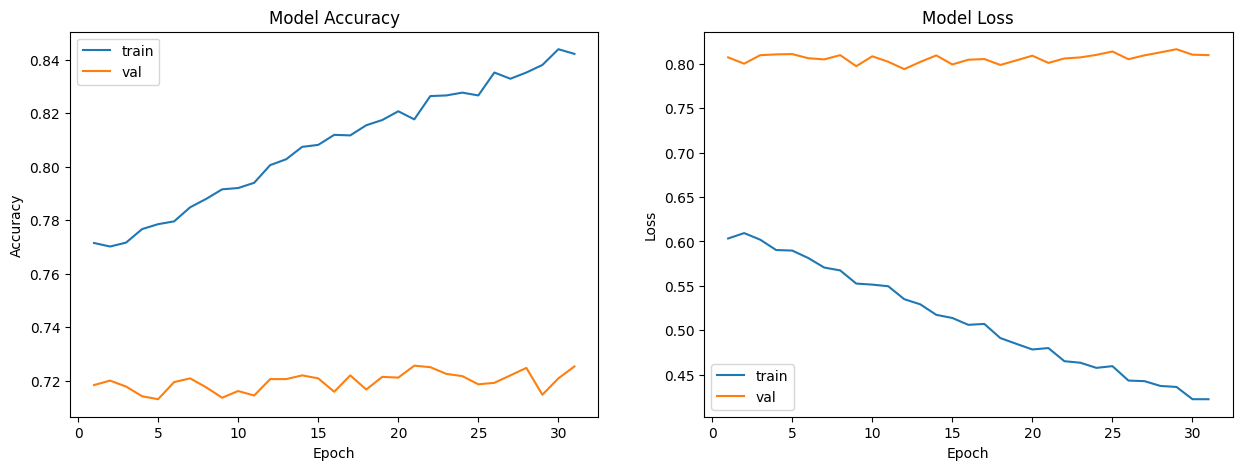

In [ ]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/last.h5',
                              save_best_only=False,
                              save_weights_only=False,
                              monitor='val_accuracy'
                              )
from keras.models import load_model
model = load_model('/content/drive/MyDrive/sgdNoNesterov31epociRamase.h5')
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(
    train_generator,
    shuffle=True,
    epochs=31,
    validation_data=test_generator,
    callbacks=[rlrop,
               checkpoint]
)

model.save('/content/drive/MyDrive/complete.h5')
plot_model_history(history)
tf.keras.backend.clear_session()